<a href="https://colab.research.google.com/github/Arbarbn/Time-Series-Analysis-Forecasting-Projects-using-Python/blob/main/Energy_Consumption_Estimation_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJM West Region Estimation Energy Consumption in MegaWatts

In [1]:
!pip install scikeras[tensorflow]

     |████████████████████████████████| 462 kB 8.0 MB/s 
     |████████████████████████████████| 97 kB 5.7 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.1
    Uninstalling importlib-metadata-4.11.1:
      Successfully uninstalled importlib-metadata-4.11.1
  Attempting uninstall: markdown
    Found existing installation: Markdown 3.3.6
    Uninstalling Markdown-3.3.6:
      Successfully uninstalled Markdown-3.3.6


In [128]:
# Data preprocessing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Min Max Scaling
from sklearn.preprocessing import MinMaxScaler

# Library TF Keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping

plt.style.use('ggplot')
palette = ["#F8766D", "#D39200", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

In [3]:
# Import library and display head data
pjmw = pd.read_csv('/content/drive/MyDrive/Data Scientist/XGBoost/PJMW_hourly.csv.zip (Unzipped Files)/PJMW_hourly.csv', parse_dates=True, low_memory=False)
pjmw.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [4]:
# Look information of data, Datetime have not in right type -> datetime64[ns]
pjmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [5]:
# Change Datetime from object into datetime64[ns]
pjmw['Datetime'] = pjmw['Datetime'].astype('datetime64')
pjmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  143206 non-null  datetime64[ns]
 1   PJMW_MW   143206 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [6]:
# Show datetime min and max
print("Min datetime:", pjmw['Datetime'].min())
print("Max datetime:", pjmw['Datetime'].max())

Min datetime: 2002-04-01 01:00:00
Max datetime: 2018-08-03 00:00:00


In [7]:
# From head, we know first data have not sorted from minimum datetime
# Sorting datetime using sort_values
pjmw.sort_values('Datetime', inplace=True, ignore_index=True)
pjmw.head()

,Datetime,PJMW_MW
0,2002-04-01 01:00:00,4374.0
1,2002-04-01 02:00:00,4306.0
2,2002-04-01 03:00:00,4322.0
3,2002-04-01 04:00:00,4359.0
4,2002-04-01 05:00:00,4436.0


In [8]:
# Show descriptive statistics of data
pjmw.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


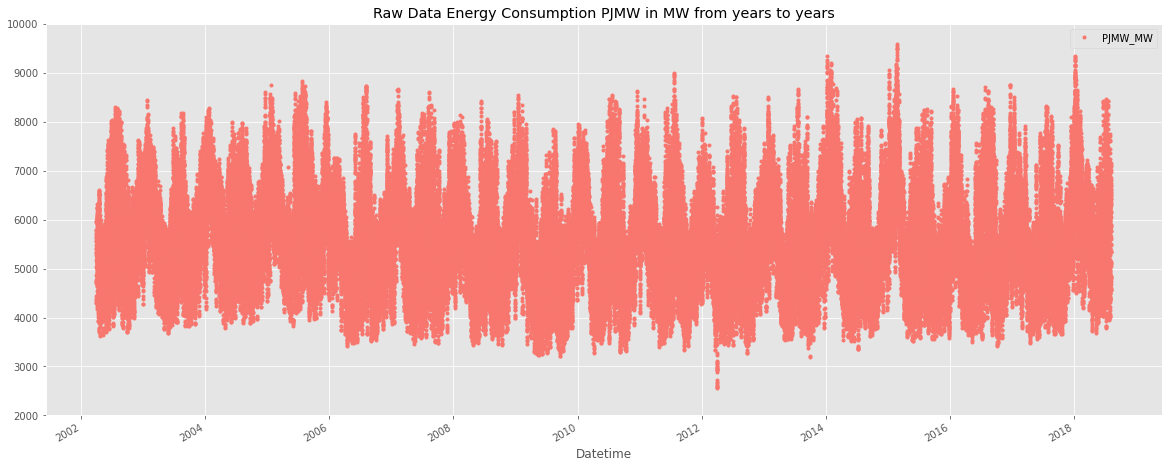

In [9]:
pjmw.plot(x='Datetime', y='PJMW_MW', figsize=(20,8), style='.', title = 'Raw Data Energy Consumption PJMW in MW from years to years', color=palette[0], legend=True)
plt.ylim(2000, 10000)
plt.show()

Choose data from 2 years ago (2015-2016) AS data training and 2017 AS data testing. Actually, this depend on what we want (use experiment)

# Train/test Split

In [10]:
split_train = '01-01-2015'
split_test = '01-01-2017'
pjmw_train = pjmw[(pjmw['Datetime']>split_train) & (pjmw['Datetime']<split_test)].copy()
pjmw_test = pjmw[pjmw['Datetime']>split_test].copy()

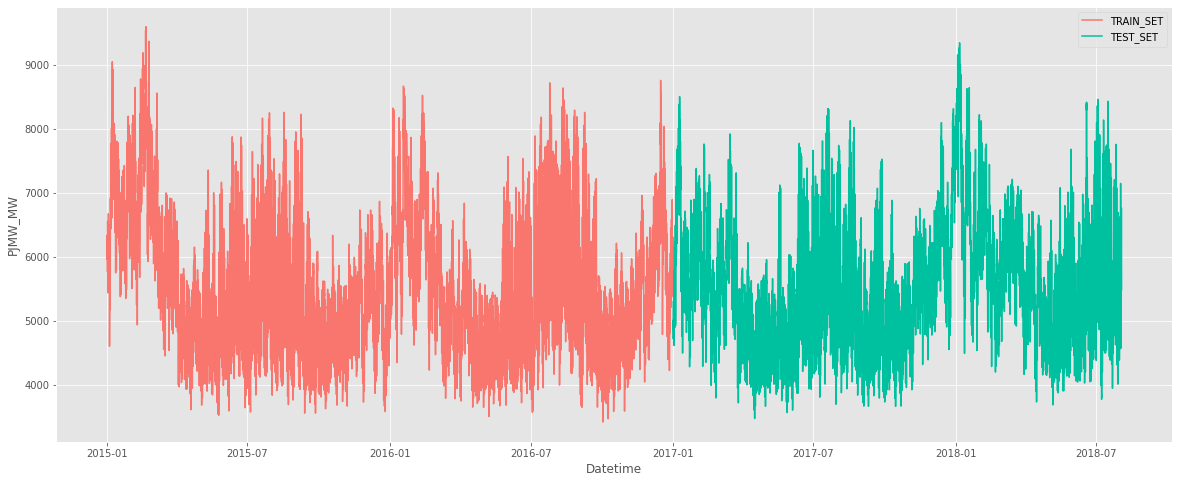

In [11]:
plt.figure(figsize=(20,8))
sns.lineplot(data= pjmw_train, x='Datetime', y='PJMW_MW', color=palette[0])
sns.lineplot(data= pjmw_test, x='Datetime', y='PJMW_MW', color=palette[3])
plt.legend(labels=['TRAIN_SET', 'TEST_SET'])
plt.show()

In [12]:
# If we look at statistics data,  we got high range min and max from 487 to 9594. Because of it, we must scaling. One of way using MinMaxScaler.
# With scaling, we can minimum range from 0 to 1 so the error can be reduce
scaler = MinMaxScaler()
scaler.fit(pjmw_train[['PJMW_MW']]) #using [[...]] to get dataframe type

MinMaxScaler()

In [13]:
pjmw_train['scaled'] = scaler.transform(pjmw_train[['PJMW_MW']])
pjmw_test['scaled'] = scaler.transform(pjmw_test[['PJMW_MW']])

In [14]:
pjmw_train

,Datetime,PJMW_MW,scaled
111767,2015-01-01 01:00:00,6184.0,0.447684
111768,2015-01-01 02:00:00,6035.0,0.423550
111769,2015-01-01 03:00:00,6049.0,0.425818
111770,2015-01-01 04:00:00,5972.0,0.413346
111771,2015-01-01 05:00:00,5956.0,0.410755
...,...,...,...
129305,2016-12-31 19:00:00,6205.0,0.451085
129306,2016-12-31 20:00:00,6005.0,0.418691
129307,2016-12-31 21:00:00,5812.0,0.387431
129308,2016-12-31 22:00:00,5646.0,0.360544


We create sliding window to make form subsequensial data.
As example : we has data -> x1, x2, x3, x4, x5, x6
so when we assume sliding_window = 3 then
as input x1, x2, x3 as output x4
as input x2, x3, x4 as output x5
etc

We must pay attention! In time series, the X data must be SORTED ascending. 

In [15]:
# Create Sliding Window function
def sliding_window(data, window_size) :
  subsequence, target = [], []  
  for i in range(len(data)-window_size):
    subsequence.append(data[i:i+window_size])
    target.append(data[i+window_size])
  X = np.stack(subsequence)
  y = np.array(target)
  return X, y

In [16]:
# Train test split into X y
window_size = 24 
X_train, y_train = sliding_window(pjmw_train[['scaled']].values, window_size)
X_test, y_test = sliding_window(pjmw_test[['scaled']].values, window_size)

Now, X and y train test have array form.

In [17]:
# We must assure shape of data train and test split
X_train.shape, y_train.shape

((17519, 24, 1), (17519, 1))

In [18]:
X_train

array([[[0.44768384],
        [0.42355037],
        [0.42581795],
        ...,
        [0.45578231],
        [0.41804341],
        [0.38241011]],

       [[0.42355037],
        [0.42581795],
        [0.41334629],
        ...,
        [0.41804341],
        [0.38241011],
        [0.34807256]],

       [[0.42581795],
        [0.41334629],
        [0.41075478],
        ...,
        [0.38241011],
        [0.34807256],
        [0.33155167]],

       ...,

       [[0.53644315],
        [0.50680272],
        [0.46857791],
        ...,
        [0.46776806],
        [0.4510852 ],
        [0.41869129]],

       [[0.50680272],
        [0.46857791],
        [0.42209265],
        ...,
        [0.4510852 ],
        [0.41869129],
        [0.38743116]],

       [[0.46857791],
        [0.42209265],
        [0.37641723],
        ...,
        [0.41869129],
        [0.38743116],
        [0.36054422]]])

## Modeling

In [20]:
def create_model_fit(LSTM_unit=64, dropout=0.2) :
  model = Sequential()
  model.add(LSTM(units=LSTM_unit, input_shape=(window_size, 1)))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout)) 
  model.add(Dense(1)) #output

  return model

In [124]:
def create_model(LSTM_unit=64, dropout=0.2) :
  model = Sequential()
  model.add(LSTM(units=LSTM_unit, input_shape=(window_size, 1)))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout)) 
  model.add(Dense(1)) #output
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
  return model

### Hypertuning

In [21]:
# Early Stopping -> if find local minima, will stop early
es = EarlyStopping(patience=5, mode='min')

In [22]:
# Create baseline model
lstm = KerasRegressor(model=create_model_fit, epochs=50, validation_split=0.1, batch_size=32, callbacks=[es], verbose=2, optimizer='adam', loss='mse', metrics=['mae'], random_state=42, shuffle=False)

In [23]:
# GridSearchCV tuning parameters
LSTM_unit = [16,32,64,128]
dropout = [0.1, 0.2, 0.3]
param_grid = dict(model__LSTM_unit=LSTM_unit, model__dropout=dropout)

In [26]:
grid = GridSearchCV(estimator=lstm, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)

In [27]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/50
493/493 - 7s - loss: 0.0123 - mean_absolute_error: 0.0784 - val_loss: 0.0042 - val_mean_absolute_error: 0.0497 - 7s/epoch - 14ms/step
Epoch 2/50
493/493 - 4s - loss: 0.0036 - mean_absolute_error: 0.0455 - val_loss: 0.0021 - val_mean_absolute_error: 0.0362 - 4s/epoch - 8ms/step
Epoch 3/50
493/493 - 4s - loss: 0.0023 - mean_absolute_error: 0.0363 - val_loss: 0.0011 - val_mean_absolute_error: 0.0265 - 4s/epoch - 8ms/step
Epoch 4/50
493/493 - 4s - loss: 0.0018 - mean_absolute_error: 0.0318 - val_loss: 0.0010 - val_mean_absolute_error: 0.0244 - 4s/epoch - 8ms/step
Epoch 5/50
493/493 - 4s - loss: 0.0015 - mean_absolute_error: 0.0291 - val_loss: 7.2001e-04 - val_mean_absolute_error: 0.0198 - 4s/epoch - 8ms/step
Epoch 6/50
493/493 - 4s - loss: 0.0014 - mean_absolute_error: 0.0276 - val_loss: 6.7916e-04 - val_mean_absolute_error: 0.0187 - 4s/epoch - 8ms/step
Epoch 7/50
493/493 - 4s - loss: 0.0011 - mean_absolute_error: 0.0249 - val_loss: 6.0371e-04 - val_mean_absolute_error: 0.0174 -

In [38]:
# Summarize Result Tuning
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" %(mean, stdev, param))

# Take best model
best_model = grid_result.best_estimator_.model

Best: 0.987455 using {'model__LSTM_unit': 64, 'model__dropout': 0.1}
0.983732 (0.002901) with: {'model__LSTM_unit': 16, 'model__dropout': 0.1}
0.979963 (0.003625) with: {'model__LSTM_unit': 16, 'model__dropout': 0.2}
0.976895 (0.002683) with: {'model__LSTM_unit': 16, 'model__dropout': 0.3}
0.987392 (0.002264) with: {'model__LSTM_unit': 32, 'model__dropout': 0.1}
0.982265 (0.005815) with: {'model__LSTM_unit': 32, 'model__dropout': 0.2}
0.978138 (0.005117) with: {'model__LSTM_unit': 32, 'model__dropout': 0.3}
0.987455 (0.003745) with: {'model__LSTM_unit': 64, 'model__dropout': 0.1}
0.986055 (0.003901) with: {'model__LSTM_unit': 64, 'model__dropout': 0.2}
0.983541 (0.003342) with: {'model__LSTM_unit': 64, 'model__dropout': 0.3}
0.986281 (0.004079) with: {'model__LSTM_unit': 128, 'model__dropout': 0.1}
0.986989 (0.002569) with: {'model__LSTM_unit': 128, 'model__dropout': 0.2}
0.982787 (0.008362) with: {'model__LSTM_unit': 128, 'model__dropout': 0.3}


In [125]:
best = create_model(LSTM_unit=64, dropout=0.1)
history = best.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32, callbacks=[es], verbose=2, validation_data=(X_test, y_test))
history.history.keys()

Epoch 1/50
493/493 - 7s - loss: 0.0074 - mae: 0.0615 - val_loss: 0.0021 - val_mae: 0.0381 - 7s/epoch - 14ms/step
Epoch 2/50
493/493 - 4s - loss: 0.0024 - mae: 0.0365 - val_loss: 7.4688e-04 - val_mae: 0.0210 - 4s/epoch - 8ms/step
Epoch 3/50
493/493 - 4s - loss: 0.0016 - mae: 0.0303 - val_loss: 7.6446e-04 - val_mae: 0.0205 - 4s/epoch - 8ms/step
Epoch 4/50
493/493 - 4s - loss: 0.0013 - mae: 0.0272 - val_loss: 4.5567e-04 - val_mae: 0.0155 - 4s/epoch - 8ms/step
Epoch 5/50
493/493 - 4s - loss: 0.0012 - mae: 0.0252 - val_loss: 4.0879e-04 - val_mae: 0.0156 - 4s/epoch - 9ms/step
Epoch 6/50
493/493 - 4s - loss: 0.0010 - mae: 0.0232 - val_loss: 6.3941e-04 - val_mae: 0.0193 - 4s/epoch - 8ms/step
Epoch 7/50
493/493 - 4s - loss: 9.5722e-04 - mae: 0.0224 - val_loss: 4.1928e-04 - val_mae: 0.0151 - 4s/epoch - 8ms/step
Epoch 8/50
493/493 - 4s - loss: 8.7245e-04 - mae: 0.0214 - val_loss: 3.8459e-04 - val_mae: 0.0153 - 4s/epoch - 8ms/step
Epoch 9/50
493/493 - 4s - loss: 8.1365e-04 - mae: 0.0210 - val_loss

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

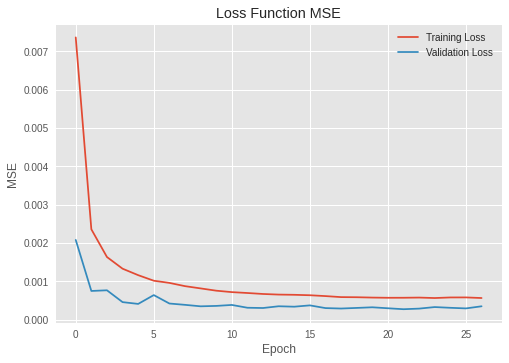

In [129]:
# Grafik Loss Function MSE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend();

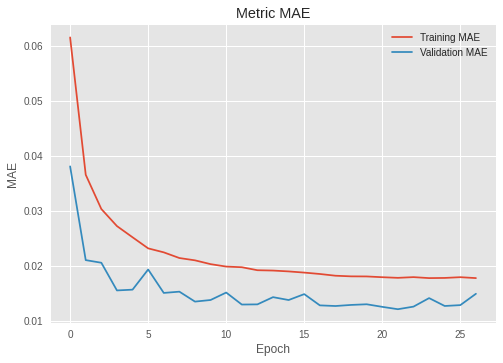

In [130]:
# Grafik Metric MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Metric MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend();

In [114]:
# Inverse data to first form
predict_train = scaler.inverse_transform(grid.predict(X_train))
true_train = scaler.inverse_transform(y_train)

predict_test = scaler.inverse_transform(grid.predict(X_test))
true_test = scaler.inverse_transform(y_test)

548/548 - 2s - 2s/epoch - 4ms/step
434/434 - 1s - 1s/epoch - 3ms/step


In [73]:
# Metric Regression
MAE_train = np.abs(true_train-predict_train)
MAE_test = np.abs(true_test-predict_test)
print("MAE Training:", np.mean(MAE_train))
print("MAE Testing:",np.mean(MAE_test))

MAE Training: 81.57636092755544
MAE Testing: 80.04031773588444


In [132]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true-y_pred)/y_true)*100
print("MAPE:", str(round(MAPE(true_test, predict_test),2))+"%")

MAPE: 1.42%


From this result, with range min and max around 9100, this is GREAT! 
if we calculate in percentage, the error is 1.42%

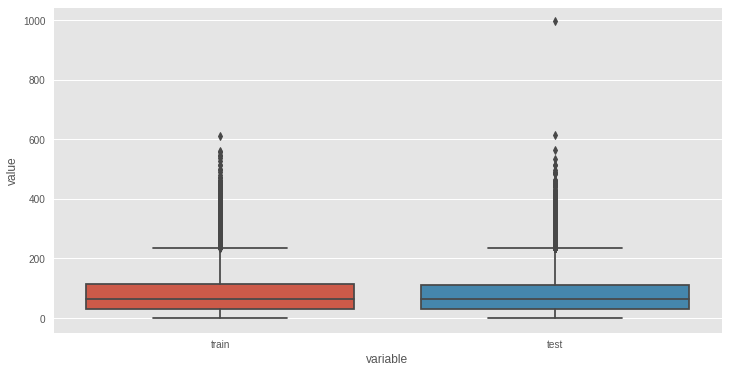

In [131]:
# Measure how good MAE using Boxplot
fig, ax = plt.subplots(figsize=(12,6))
mae = pd.DataFrame(MAE_train, columns=['train'])
mae['test'] = pd.DataFrame(MAE_test)
sns.boxplot(x="variable", y="value", data=pd.melt(mae))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


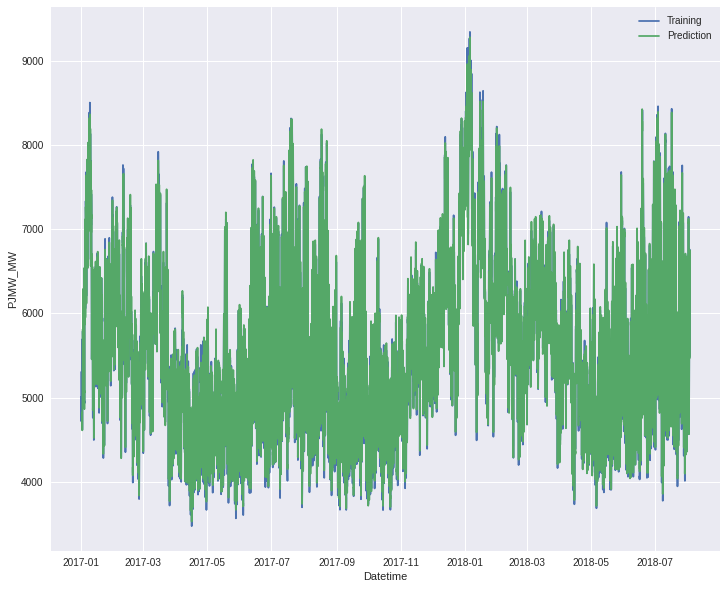

In [107]:
# Plot test data
pjmw_test['prediction'] = np.nan
pjmw_test['prediction'][-len(predict_test):] = predict_test[:,0]

plt.figure(figsize=(12,10))
sns.lineplot(data=pjmw_test, x='Datetime', y='PJMW_MW', label='Training')
sns.lineplot(data=pjmw_test, x='Datetime', y='prediction', label='Prediction');

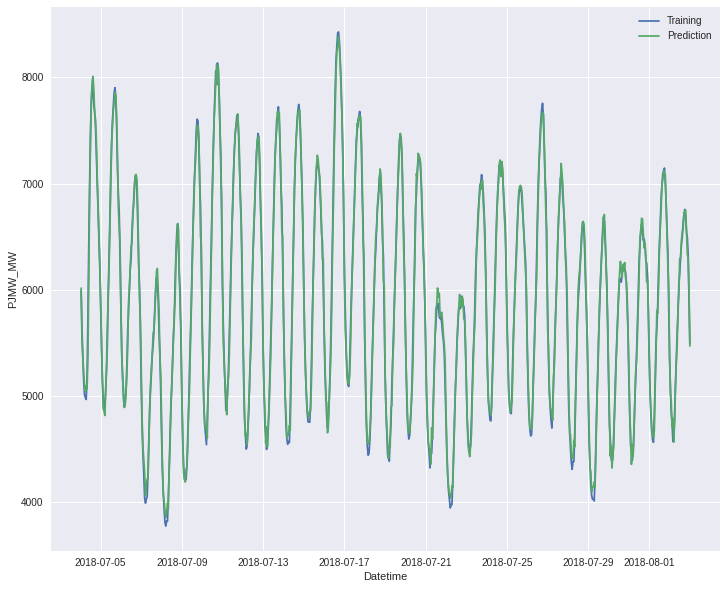

In [106]:
# Plot last month
plt.figure(figsize=(12,10))
sns.lineplot(data=pjmw_test[-24*30:], x='Datetime', y='PJMW_MW', label='Training')
sns.lineplot(data=pjmw_test[-24*30:], x='Datetime', y='prediction', label='Prediction');